# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第2节 择时策略的优化</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

首先导入abupy中本节使用的模块：

In [1]:
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


上一节编写了AbuFactorBuyBreak和AbuFactorSellBreak，做为择时买入策略和择时卖出策略，本节将继续使用这两个策略，
通过混入其它卖出策略来提高优化交易效果。

备注：已将AbuFactorBuyBreak和AbuFactorSellBreak做为abupy内置策略示例因子在项目中，所以本节不重复编写因子，直接从abupy中import因子，如下所示

In [2]:
from abupy import AbuFactorBuyBreak, AbuFactorSellBreak

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
# 使用120天向下突破为卖出信号
sell_factor1 = {'xd': 120, 'class': AbuFactorSellBreak}

### 1  基本止盈止损策略

上一节的策略大多数的交易卖出因子都生效了，但效果很不好，量化交易系统一般都会有止盈策略和止损策略。

下面使用abupy中内置的基本止盈止损策略AbuFactorAtrNStop做回测，即使用AbuFactorAtrNStop和AbuFactorSellBreak两个卖出因子策略并行同时生效, 交易结果如下所示

备注：

AbuFactorAtrNStop是真实波幅atr作为最大止盈和最大止损的常数值:

* 当stop_win_n 乘以 当日atr > 买入价格 － 当日收盘价格：止损卖出，如下止损n ＝ 0.5
* 当stop_loss_n 乘以 当日atr < 当日收盘价格 －买入价格：止盈卖出，如下止盈n ＝ 3.0

更多详情请阅读abupy中AbuFactorAtrNStop代码实现

pid:7773 pick times complete:100.0%


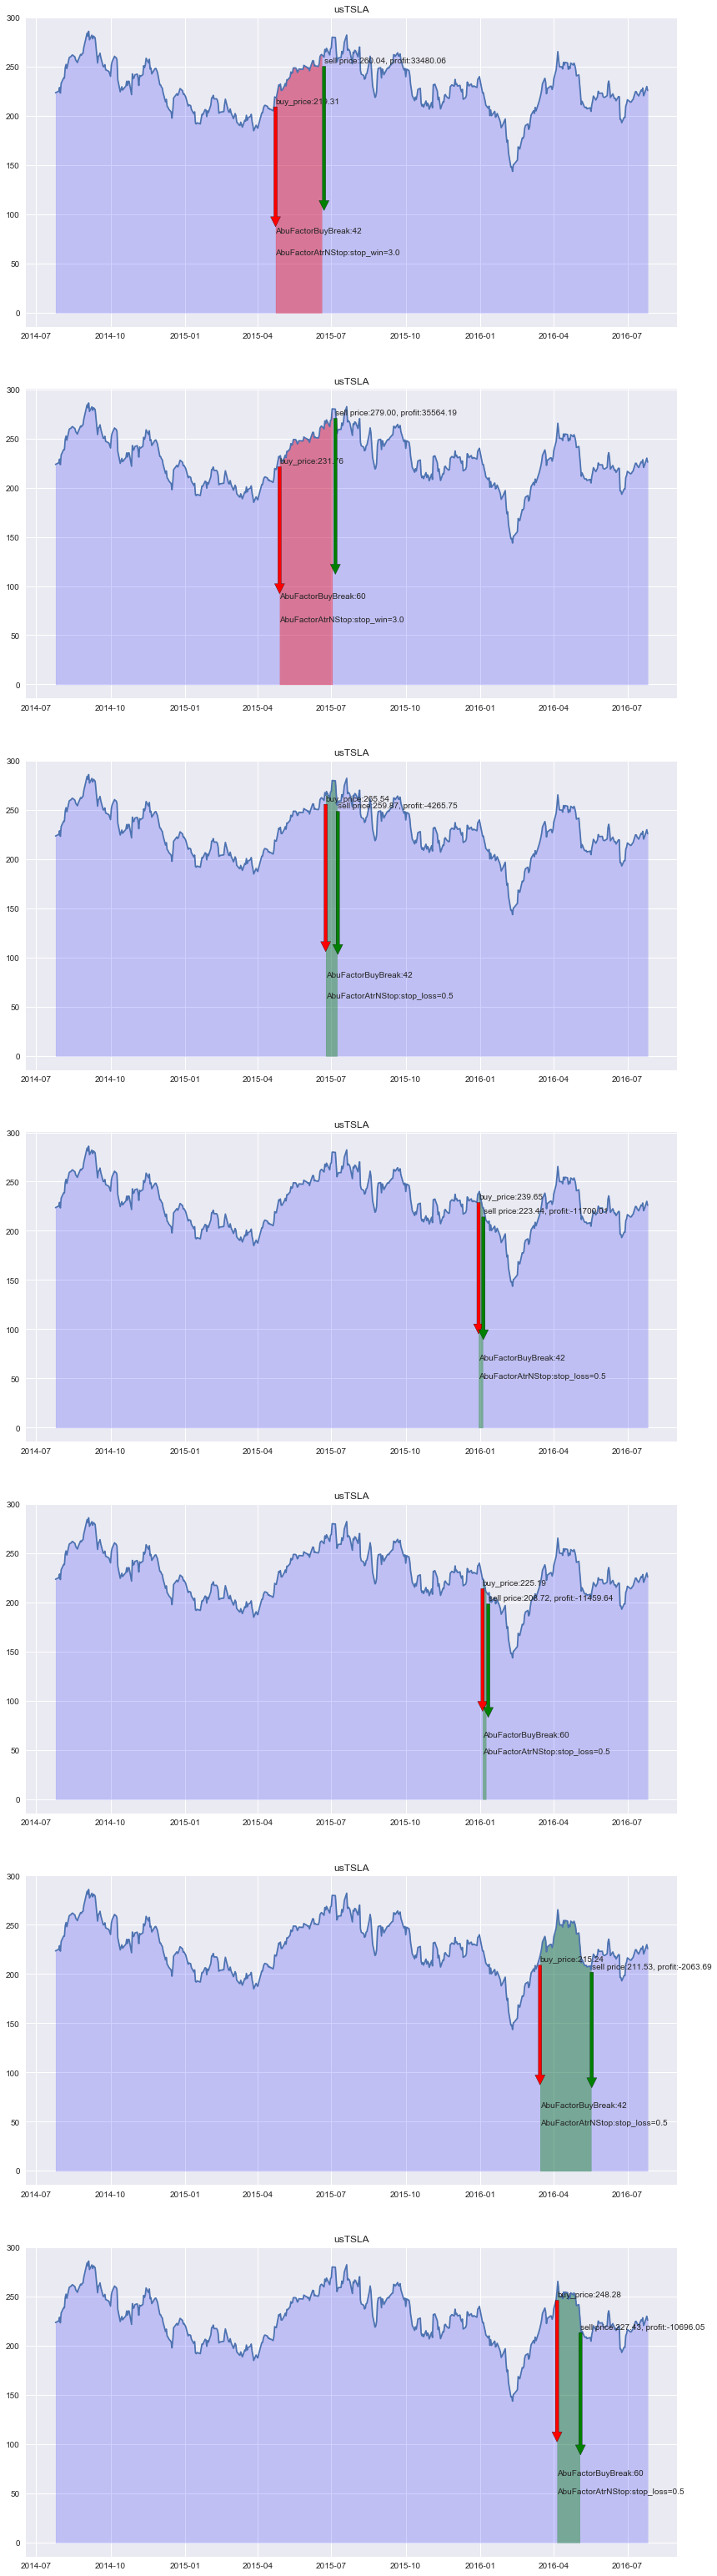

pid:7773 done!


In [3]:
from abupy import AbuFactorAtrNStop
from abupy import ABuPickTimeExecute, AbuBenchmark, AbuCapital

# 趋势跟踪策略止盈要大于止损设置值，这里0.5，3.0
sell_factor2 = {'stop_loss_n': 0.5, 'stop_win_n': 3.0,
                'class': AbuFactorAtrNStop}

# 两个卖出因子策略并行同时生效
sell_factors = [sell_factor1, sell_factor2]
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            sell_factors,
                                                                            capital, show=True)

### 2. 风险控制止损策略

可以看到效果比之前好多了，下面再加入一些其它卖出策略，量化交易系统中一般都会有风险控制策略，比如当股票今天价格开始剧烈下跌，采取果断平仓措施。

可以使用abupy中内置的风险控制止损策略AbuFactorPreAtrNStop

* 策略中继续使用真实波幅atr作为常数值: 当今日价格下跌幅度 > 当日atr 乘以 pre_atr_n（下跌止损倍数）卖出股票, 本例使用pre_atr_n＝1.0

更多详情请阅读abupy中AbuFactorPreAtrNStop代码实现

sell_factors中加入AbuFactorPreAtrNStop卖出因子，三个卖出因子策略并行同时生效:

pid:7773 pick times complete:100.0%


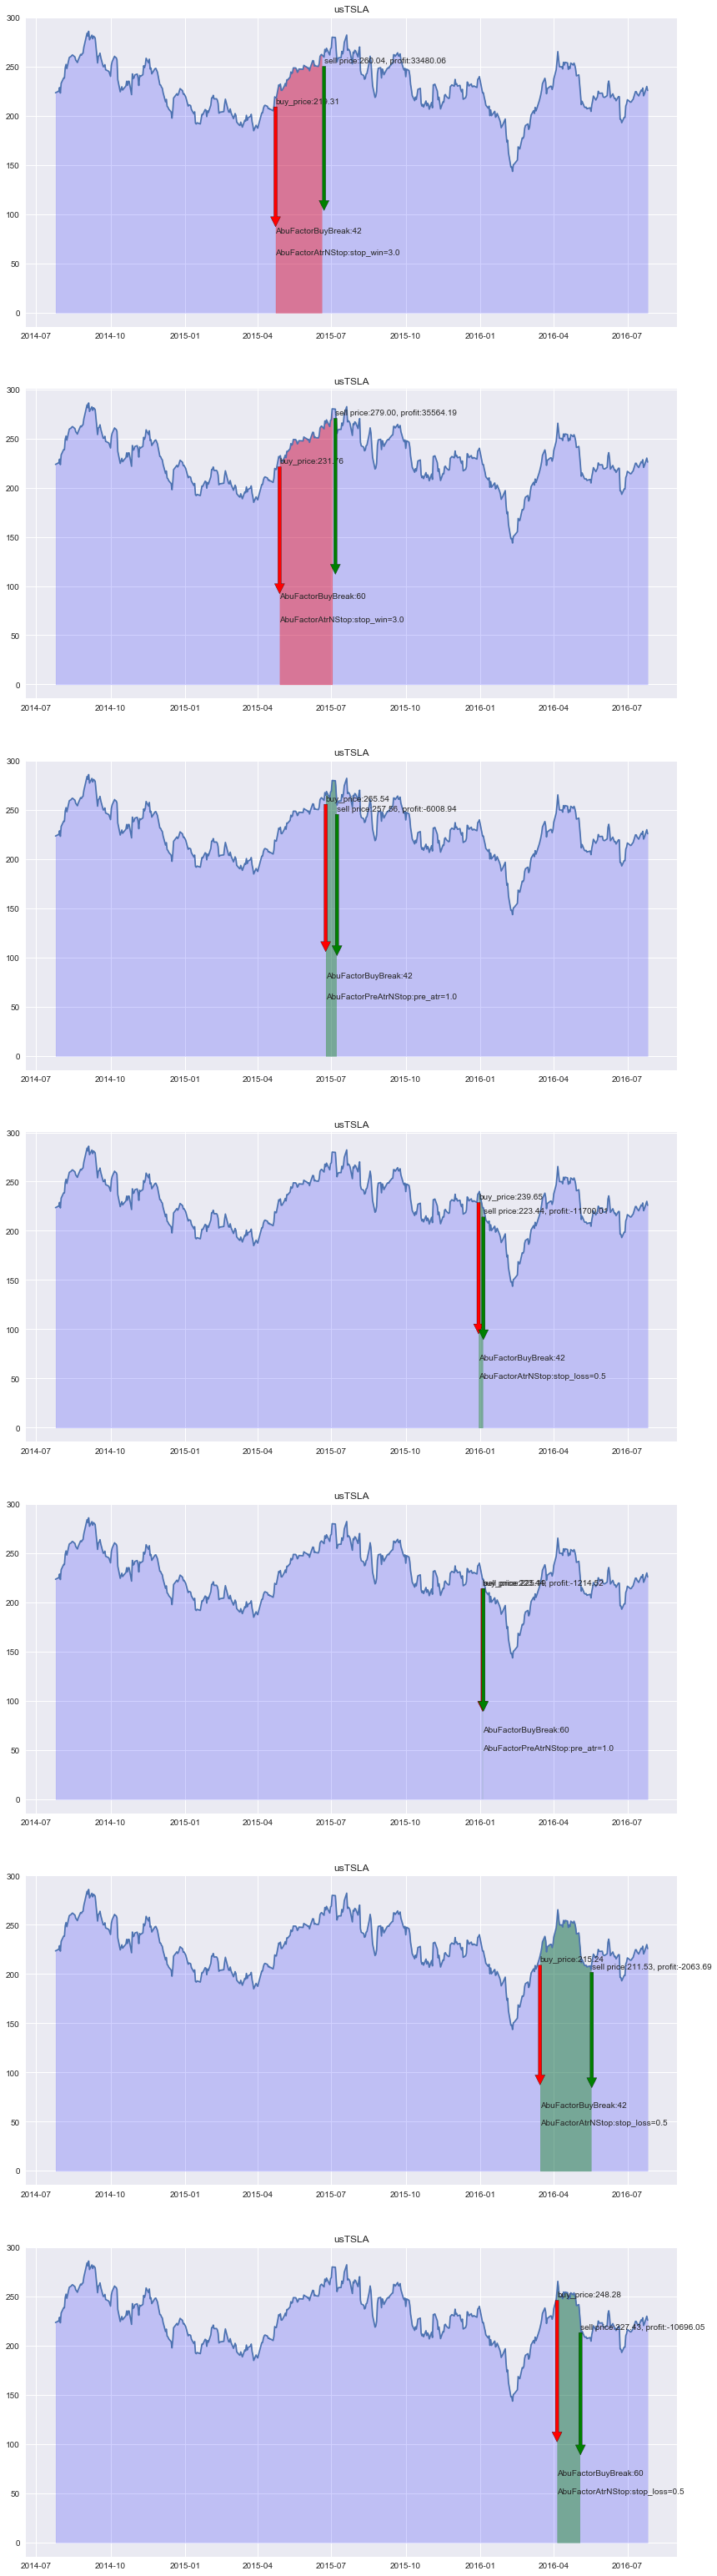

pid:7773 done!


In [4]:
from abupy import AbuFactorPreAtrNStop

# 暴跌止损卖出因子形成dict
sell_factor3 = {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.0}
# 三个卖出因子同时生效，组成sell_factors
sell_factors = [sell_factor1, sell_factor2, sell_factor3]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            sell_factors,
                                                                            capital,
                                                                            show=True)

如上所示由于使用AbuFactorPreAtrNStop，效果继续变好，有两笔交易通过AbuFactorPreAtrNStop进行卖出，阻止了进一步的交易损失：

![](./image/1.1.png)
![](./image/1.2.png)

### 3. 利润保护止盈策略

接下来注意下图这笔交易，读者会发现本来有很多盈利的，但是由于止盈没有达到，所以最后变成了亏损

![](./image/1.3.png)

下面通过添加abupy内置的保护盈利的卖出因子AbuFactorCloseAtrNStop来使上图那笔交易获利：

* AbuFactorCloseAtrNStop atr移动止盈策略，当买入股票有一定收益后，如果股价下跌幅度超过close_atr_n乘以当日atr：则保护止盈卖出，如下示例使用close_atr_n＝1.5

更多详情请阅读abupy中AbuFactorCloseAtrNStop代码实现

sell_factors加入AbuFactorCloseAtrNStop卖出因子，四个卖出因子策略并行同时生效

pid:7773 pick times complete:100.0%


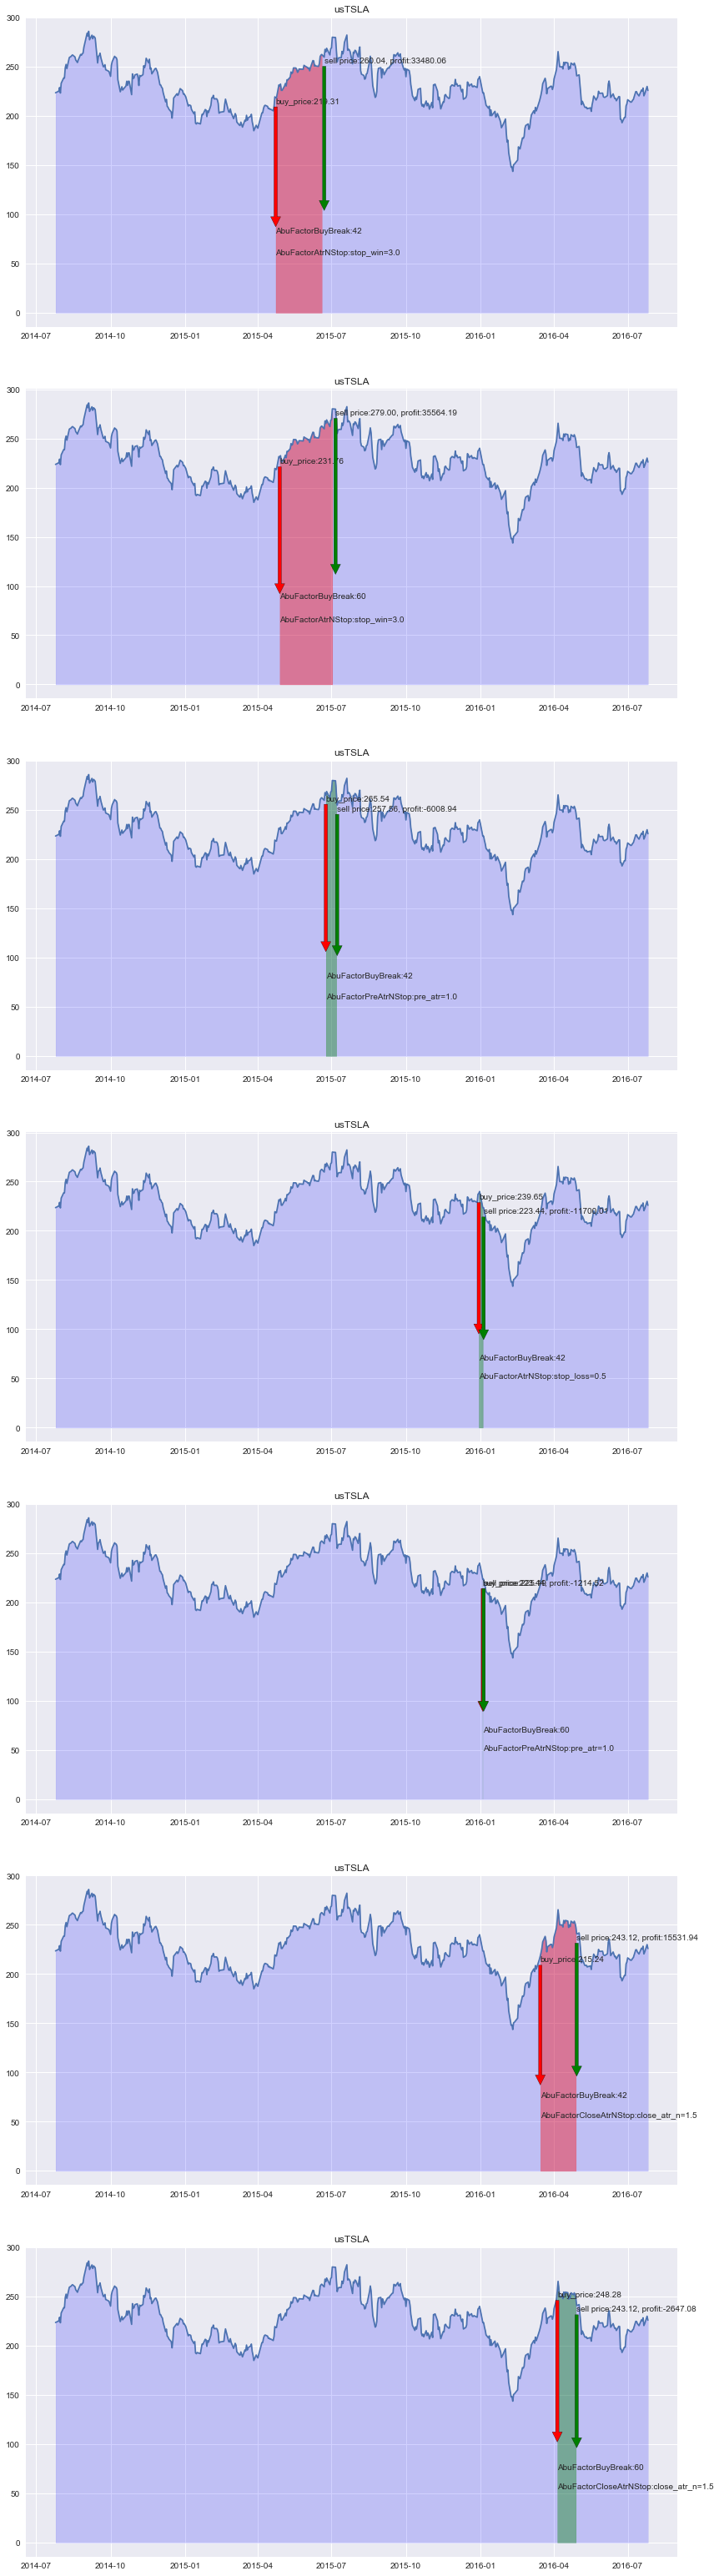

pid:7773 done!


In [5]:
from abupy import AbuFactorCloseAtrNStop

# 保护止盈卖出因子组成dict
sell_factor4 = {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
# 四个卖出因子同时并行生效
sell_factors = [sell_factor1, sell_factor2, sell_factor3,
                sell_factor4]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            sell_factors,
                                                                            capital,
                                                                            show=True)

从上图交易结果可以看到最终那笔失败的交易也盈利卖出了。

注意：

1. 上面的很多拟合优化操作在实际应用中是不可取的，比如最后的那个使用AbuFactorCloseAtrNStop使交易盈利以及我之后即将讲解的另一些手段使整体交易变好的做法，不应该因为某些特定股票或者特定交易修改参数或者添加因子等方式使结果变好，这样就是过拟合择时交易系统，将会在下一章节来示例如何挑选参数及因子的选择问题，本节内容主要是为了讲解择时系统的示例。

2. 读者可能注意到我在多个卖出因子，还有即将讲到的仓位控制都使用了atr，但请不要误会我不是强调atr有多重要多好，只不过是我想尽量使用一个概念来完成尽可能多的任务，不必反复引入过多的交易概念，因为篇幅有限，且容易引发阅读困难

3. 本节只是示例卖出策略的使用，更多个性化的卖出策略可根据自己的交易买入策略与交易风格自行编写。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)
更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://union-click.jd.com/jdc?d=ddV9Uw)

更多关于量化交易相关请稍后阅读《量化交易之路》暂未出版

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)